## Chapter 3 - Linear Regression

In [11]:
import numpy as np
import pandas as pd 

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

import statsmodels.api as sm
from patsy import dmatrices

In [2]:
file_name = 'Advertising.csv'
df_adv = pd.read_csv(f'data/{file_name}', index_col=0)

In [3]:
df_adv.head(2)

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4


### Simple Linear Regression

In [4]:
def simple_least_squares(x, y):
    """Returns the estimates of intercept and slope for the
    simple linear regression model."""
    beta1 = np.sum((x-np.mean(x))*(y-np.mean(y)))/np.sum(np.power(x-np.mean(x),2))
    beta0 = np.mean(y) - beta1*np.mean(x)
    return beta0, beta1

In [5]:
def get_rss(beta0, beta1, x, y_true):
    """Return the residual sum of squares."""
    y_hat = beta0 + beta1*x
    return np.sum(np.power(y_true-y_hat,2))

In [70]:
coeffs = simple_least_squares(df_adv['TV'],df_adv['sales'])

(-10, 310)

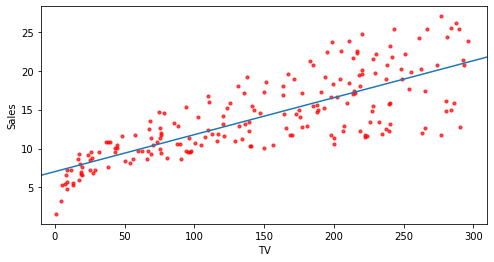

In [7]:
x = np.linspace(-10, 310, 100)
fig = plt.figure(figsize=(8,4))
plt.scatter(df_adv['TV'], df_adv['sales'], marker='o', color='r', alpha=0.7, s = 10)
plt.plot(x, coeffs[0]+x*coeffs[1], linestyle='solid')
plt.xlabel('TV')
plt.ylabel('Sales')
plt.xlim((-10,310))

In [8]:
get_rss(coeffs[0], coeffs[1], df_adv['TV'],df_adv['sales'])

2102.5305831313512

In [9]:
beta0_vec = np.linspace(2, 12, 10)
beta1_vec = np.linspace(0.02, 0.07, 10)
X, Y = np.meshgrid(beta0_vec, beta1_vec, indexing='xy')
Z = np.zeros((beta0_vec.size,beta1_vec.size))
for index, x in np.ndenumerate(Z):
    Z[index] = get_rss(X[index], Y[index], df_adv['TV'], df_adv['sales'])

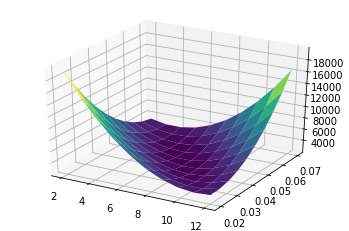

In [10]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

#### Testing the bias of least square estimators

Defining population:

In [58]:
def sample(size):
    beta0, beta1 = 2, 3
    mu, sigma = 0, 2
    x = np.linspace(-2, 2, size)
    y = beta0 + beta1*x + np.random.normal(mu, sigma, size)
    return np.column_stack((x,y))

In [59]:
sample0 = sample(50)

In [60]:
coeffs0 = simple_least_squares(sample0[:,0],sample0[:,1])

Text(0, 0.5, 'Y')

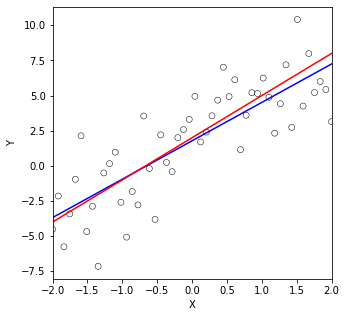

In [62]:
x = np.linspace(-2, 2, 30)
fig = plt.figure(figsize=(5,5))
plt.scatter(sample0[:,0], sample0[:,1], facecolors='none', linewidths=.5, edgecolors='black')
plt.plot(x, coeffs0[0]+x*coeffs0[1], linestyle='solid', c='blue', label='least squares line')
plt.plot(x, 2+x*3, linestyle='solid', c='red', label='population line')
plt.xlim((-2,2))
plt.xlabel('X')
plt.ylabel('Y')

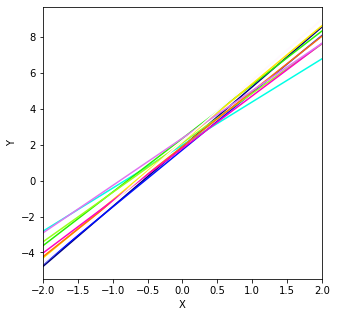

In [68]:
# define np array to gether the coofs -> calculate mean
num_plots = 10
colormap = plt.cm.gist_ncar 
colors = [colormap(i) for i in np.linspace(0, 1, num_plots)]

x = np.linspace(-2, 2, 30)
fig = plt.figure(figsize=(5,5))
plt.xlim((-2,2))
plt.xlabel('X')
plt.ylabel('Y')
for i in range(num_plots):
    samplei = sample(50)
    coeffsi = simple_least_squares(samplei[:,0],samplei[:,1])
    plt.plot(x, coeffsi[0]+x*coeffsi[1], linestyle='solid', c=colors[i])

In [77]:
# simple Monte Carlo simulation
def MonteCarlo(n_simulations):
    beta0_coeffs = []
    beta1_coeffs = []
    
    for i in range(n_simulations):
        samplei = sample(80)
        coeffsi = simple_least_squares(samplei[:,0],samplei[:,1])
        beta0_coeffs.append(coeffsi[0])
        beta1_coeffs.append(coeffsi[1])
        
    return sum(beta0_coeffs)/len(beta0_coeffs), sum(beta1_coeffs)/len(beta1_coeffs)

In [78]:
MonteCarlo(10000)

(1.9997666693431235, 2.9962852334022316)

The mean of 10 000 least square estimates of coefficients is close to the population coefficients - 2 and 3. The least squared produces unbiased estimators. 

### Multiple linear regression

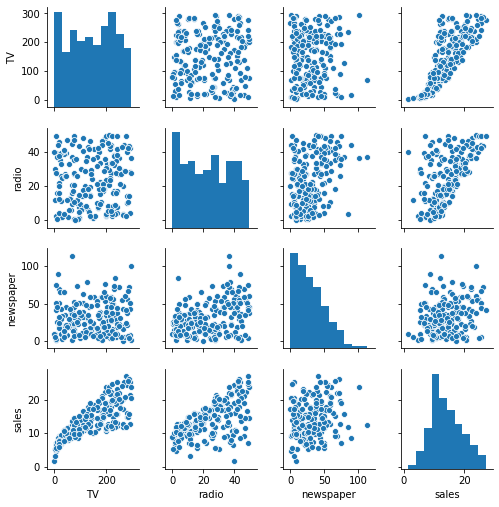

In [16]:
sns.pairplot(df_adv, height=1.8)

In [82]:
y, X = dmatrices('sales ~ TV + radio + newspaper', data=df_adv, return_type='dataframe')

In [85]:
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 15 Oct 2020   Prob (F-statistic):           1.58e-96
Time:                        21:01:31   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.0

**Standard error** - the average amount that the estimator differs from the actual value from the population

**95% Confidence intervals** - estimator +/- 2*SE(estimator). Range of values that contains the true value of coeffictient with 95% probability

**t-statistics** - number of standard deviations the the estimator of coefficient is from zero (if the null hypothesis is beta=0)

**p-value** - the probability that we will t-statistics value to be equal to the value computed or higher, when assuming that null hypothesis holds. If this probability is low (low p-value), we reject the null hypothesis and declare that the relationship between Xj and Y exists.  

In the OLS results summary, we can see that newspaper variable is not statistically significant. What is interesting is the fact that fitting the model with only this predictor leads to other results:

In [88]:
y, X = dmatrices('sales ~ newspaper', data=df_adv, return_type='dataframe')

In [89]:
mod2 = sm.OLS(y, X)
res2 = mod2.fit()
print(res2.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3514      0.621     19.876      0.000      11.126      13.577
newspaper      0.0547      0.017      3.300      0.001       0.022       0.087


The newspaper variable is highly correlated with the other two predictors - TV and radio. 
There is a tendency to spend more on newspaper advertising in markets where more is spent on radio/TV advertising:

In [92]:
df_adv.loc[:, df_adv.columns != 'sales'].corr()

,TV,radio,newspaper
TV,1.000000,0.054809,0.056648
radio,0.054809,1.000000,0.354104
newspaper,0.056648,0.354104,1.000000


According to conducted multiple regression, there is no relationship between newspaper spend and sales, and there is  positive relationship between TV and radio spend and sales. In the markets that spend more on TV/radio, the spend on advertisers also will be higher. 

Therefore, in simple regression higher values of newspaper spend will be associated with higher values of sales, even though such relationship doesn't really exists.

***

**R^2 Statistics** - proportion of variance in reposonse Y explained by the model to total inherent variance of Y. The advantege over RSS is that it is independent of scale of Y (not measured in units of Y), with values typically between 0 and 1 (There is a possibility of negative values of R^2 in case of really poor models)

**F-statistic** - allows to test whether there is a relationship between the response and predictors in multiple regression setting. H0 is that all coefficients are equal 0. H1 is that there is at least one non-zero coefficient.

It is useful in the case of large values of predictors. Example: We assume that number of predictors = 100 and the null hypothesis - H0: beta0 = beta1 = ... = betap = 0 holds (there is no variable that is truly asssociated with the response). In this situation about 5% of predicors will have p-value lower that 0.05 by chance - we will incorrectly conclude that there is relationship. 

F-statistic doesn't suffer from this problem because it adjusts for the number of predictors - when H0 is true, there is only 5% chance that p-value for F-statistics will be below 0.05 by chance, regardless of the number of predictors or observations.

### Removing the Additive Assumption

Check whether spending money on radio advertising increases the effectivenes of TV advertising, or vice versa (interaction/synergy effect):

In [17]:
y, X = dmatrices('sales ~ TV + radio + TV*radio', data=df_adv, return_type='dataframe')

In [18]:
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary().tables[1])

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1963.
Date:                Sat, 17 Oct 2020   Prob (F-statistic):          6.68e-146
Time:                        16:08:43   Log-Likelihood:                -270.14
No. Observations:                 200   AIC:                             548.3
Df Residuals:                     196   BIC:                             561.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7502      0.248     27.233      0.0

The model with interaction effect between TV and radio variables is superior to the model with only main effects. The p-value for interaction term is low, inidcating that there is strong evidence that beta3 is not equal to zero. R^2 (0.9676) is higher than R^2 of main model (0.89).

Increase in TV advertising of 1000 will increase sales by (beta1 + beta3*radio)* 1000 = 19+1.1* radio units
Incerase in radio advertising of 1000 will increase sales by (beta2 + beta3*radio)* 1000 = 29+1.1* TV units

#### Interaction effect with quantitative variables

In [33]:
file_name2 = 'Credit.csv'
df_credit = pd.read_csv(f'data/{file_name2}', index_col=0)

In [37]:
# get dummy varaible for Student 
df_credit = pd.concat((df_credit.loc[:,df_credit.columns != 'Student'], 
          pd.get_dummies(df_credit['Student'],drop_first=True).rename({'Yes':'Student_Yes'}, axis=1)), axis=1)

In [40]:
df_credit.head(10).T

,1,2,3,4,5,6,7,8,9,10
Income,14.891,106.025,104.593,148.924,55.882,80.18,20.996,71.408,15.125,71.061
Limit,3606,6645,7075,9504,4897,8047,3388,7114,3300,6819
Rating,283,483,514,681,357,569,259,512,266,491
Cards,2,3,4,3,2,4,2,2,5,3
Age,34,82,71,36,68,77,37,87,66,41
Education,11,15,11,11,16,10,12,9,13,19
Gender,Male,Female,Male,Female,Male,Male,Female,Male,Female,Female
Married,Yes,Yes,No,No,Yes,No,No,No,No,Yes
Ethnicity,Caucasian,Asian,Asian,Asian,Caucasian,Caucasian,African American,Asian,Caucasian,African American
Balance,333,903,580,964,331,1151,203,872,279,1350


Goal: predict balance using Income and Student variables

1) Model without interactions 

In [45]:
y_balance, X_balance = dmatrices('Balance ~ Income + Student_Yes', data=df_credit, return_type='dataframe')

In [46]:
mod_balance = sm.OLS(y_balance, X_balance)
res_balance = mod_balance.fit()
print(res_balance.summary().tables[1])

                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     211.1430     32.457      6.505      0.000     147.333     274.952
Income          5.9843      0.557     10.751      0.000       4.890       7.079
Student_Yes   382.6705     65.311      5.859      0.000     254.272     511.069


This amounts to fitting two parallel lines to the data, one for students, one for non-students. The lines have the same slope (beta1) and different intercepts (beta0+beta2 for students vs beta0 for non-students). the fact that lines are parallel means that the average effect on Y of one unit increase doesn't depend on whether person is or not a student. If we want to address it, we need to add interaction income * student.

In [47]:
y_balance, X_balance = dmatrices('Balance ~ Income + Student_Yes + Income*Student_Yes', 
                                 data=df_credit, return_type='dataframe')

In [48]:
mod_balance = sm.OLS(y_balance, X_balance)
res_balance = mod_balance.fit()
print(res_balance.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            200.6232     33.698      5.953      0.000     134.373     266.873
Income                 6.2182      0.592     10.502      0.000       5.054       7.382
Student_Yes          476.6758    104.351      4.568      0.000     271.524     681.827
Income:Student_Yes    -1.9992      1.731     -1.155      0.249      -5.403       1.404


Once again, we have two different regression lines for the students and the non-students. Those line have now different intecepts (beta0 + beta2 for students vs beta0), as well as different slopes (beta1 + beta3 for student vs beta3). This allows to consider the possibility that changes in income may affect the credit card balances of students and non-students differently.

Text(0.5, 1.0, 'Model with interaction term')

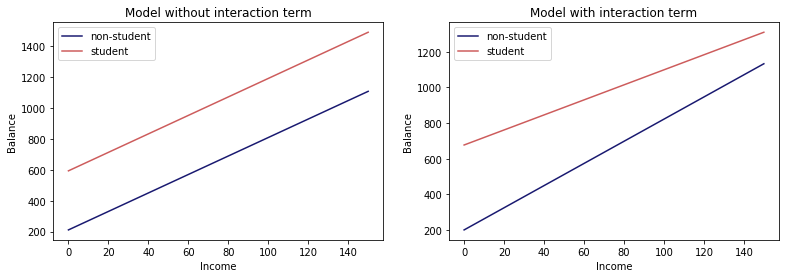

In [118]:
x = np.linspace(0,150,50)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
ax1.plot(x, 211.1430+5.9843*x, linestyle='solid', c='midnightblue', label='non-student')
ax1.plot(x, 211.1430+382.6705+5.9843*x, linestyle='solid', c='indianred', label='student')
ax1.set_xlabel('Income')
ax1.set_ylabel('Balance')
ax1.legend()
ax1.set_title('Model without interaction term')

ax2.plot(x, 200.6232+6.2182*x, linestyle='solid', c='midnightblue', label='non-student')
ax2.plot(x, 200.62320+476.6758+6.2182*x-1.9992*x, linestyle='solid', c='indianred', label='student')
ax2.set_xlabel('Income')
ax2.set_ylabel('Balance')
ax2.legend()
ax2.set_title('Model with interaction term')

### Non-linear Relationships

In [68]:
file_name3 = 'Auto.csv'
df_auto = pd.read_csv(f'data/{file_name3}', index_col=0)
df_auto.reset_index(inplace=True)

In [80]:
df_auto['horsepower'] = pd.to_numeric(df_auto['horsepower'], errors='coerce')

In [81]:
df_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           397 non-null    float64
 1   cylinders     397 non-null    int64  
 2   displacement  397 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        397 non-null    int64  
 5   acceleration  397 non-null    float64
 6   year          397 non-null    int64  
 7   origin        397 non-null    int64  
 8   name          397 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 28.0+ KB


In [83]:
y_auto, X_auto = dmatrices('mpg ~ horsepower', data=df_auto, return_type='dataframe')

In [84]:
mod_auto = sm.OLS(y_auto, X_auto)
res_auto = mod_auto.fit()
print(res_auto.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145


In [88]:
print(res_auto.rsquared)

0.6059482578894348


In [90]:
y_auto, X_auto = dmatrices('mpg ~ horsepower + np.power(horsepower, 2)', data=df_auto, return_type='dataframe')

In [91]:
mod_auto = sm.OLS(y_auto, X_auto)
res_auto = mod_auto.fit()
print(res_auto.summary().tables[1])

                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  56.9001      1.800     31.604      0.000      53.360      60.440
horsepower                 -0.4662      0.031    -14.978      0.000      -0.527      -0.405
np.power(horsepower, 2)     0.0012      0.000     10.080      0.000       0.001       0.001


In [92]:
print(res_auto.rsquared)

0.6875590305127516


In [96]:
y_auto, X_auto = dmatrices('mpg ~ horsepower + np.power(horsepower, 2) + np.power(horsepower, 3)', 
                           data=df_auto, return_type='dataframe')

In [97]:
mod_auto = sm.OLS(y_auto, X_auto)
res_auto = mod_auto.fit()
print(res_auto.summary().tables[1])

                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  60.6848      4.563     13.298      0.000      51.713      69.657
horsepower                 -0.5689      0.118     -4.824      0.000      -0.801      -0.337
np.power(horsepower, 2)     0.0021      0.001      2.193      0.029       0.000       0.004
np.power(horsepower, 3) -2.147e-06   2.38e-06     -0.903      0.367   -6.82e-06    2.53e-06


In [99]:
df_auto.horsepower.describe()

count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: horsepower, dtype: float64

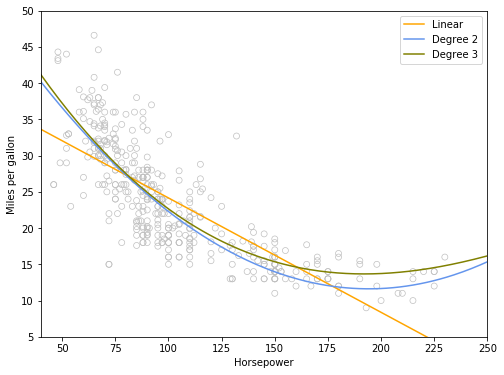

In [116]:
x = np.linspace(40,250,200)
fig = plt.figure(figsize=(8,6))
plt.xlabel('Horsepower')
plt.ylabel('Miles per gallon')
plt.scatter(x=df_auto['horsepower'], y=df_auto['mpg'], facecolors='none', linewidths=.7, edgecolors='silver')
plt.plot(x, 39.9359+x*-0.1578, linestyle='solid', c='orange', label='Linear')
plt.plot(x, 56.9001+x*-0.4662+np.power(x,2)*0.0012, linestyle='solid', c='cornflowerblue', label='Degree 2')
plt.plot(x, 60.6848+x*-0.5689+np.power(x,2)*0.0021+np.power(x,3)*-2.147e-06,
         linestyle='solid', c='olive', label='Degree 3')
plt.xlim((40,250))
plt.ylim((5,50))
plt.legend()